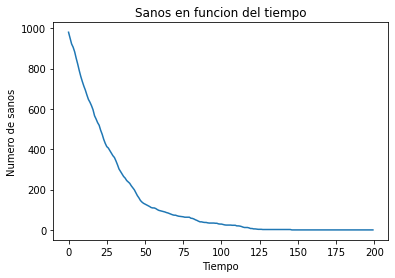

In [1]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math as mt

const_N = 1000 # Cantidad de personas
const_proporcion_contagiados = 0.02 # Porcentaje de contagiados iniciales
const_tamanio_mapa = 200 # Tamanio del mapa
const_instantes_de_tiempo = 200 # Instantes simulados

# Esto en "True" es el ej 8
correlated_random_walking = True

# Se puede observar que cuando se activa la opcion de correlated walking el contagio de la totalidad de las
# personas se produce considerablemente mas rapido, esto es debido a que las personas tienden por momentos
# a desplazarse mayores distancias en determinados sentidos, lo que provoca el acercamiento con otras personas
# y por lo tanto aumenta la probabilidad de contagio.

const_prob_cercana_contagio = 0.7   # celdas <= 3
const_prob_lejana_contagio = 0.5   # 3 < celdas <= 6

const_up = 0
const_down = 1
const_right = 2
const_left = 3

class Persona:

  def __init__(self, tipo_de_persona, esta_enfermo, pos_x, pos_y):
    turnos = {"A":1, "B":2, "C":4}
    self._turnos_de_espera = turnos[tipo_de_persona]
    self._esta_enfermo = esta_enfermo
    self._turnos_esperados = 0
    self._pos_x = pos_x
    self._pos_y = pos_y
    self._movimiento_anterior = None

  def intentar_moverse(self):
        self._turnos_esperados += 1

        if self._turnos_esperados == self._turnos_de_espera:
            self._turnos_esperados = 0
            return True

        return False

  def intentar_contagiar(self, probabilidad_de_contagio):
    if (not self._esta_enfermo):
      if rd.uniform(0, 1) <= probabilidad_de_contagio:
        self._esta_enfermo = True
        
  def puede_contagiar(self):
    return (self._esta_enfermo)

  def obtener_posicion(self):
    return self._pos_x, self._pos_y

  def modificar_posicion(self, x, y):
    self._pos_x = x
    self._pos_y = y
    
  def obtener_movimiento_anterior(self):
    return self._movimiento_anterior

  def modificar_ultimo_movimiento(self, movimiento):
    self._movimiento_anterior = movimiento


class Pandemia:

  def __init__(self):
    self.filas = const_tamanio_mapa
    self.columnas = const_tamanio_mapa
    self.mapa = generar_mapa(const_tamanio_mapa, const_tamanio_mapa)
    self.personas = poblar_mapa(self.mapa, const_N)
    self.lista_instantes = []
    self.lista_contagiados = []
    self.lista_sanos = []
    self.instantes_pasados = 0

  def info_personas(self):
      posicion_x = []
      posicion_y = []
      estado = []

      for persona in self.personas:
          x, y = persona.obtener_posicion()
          posicion_y.append(y)
          posicion_x.append(x)
          if persona.puede_contagiar():
              estado.append('red')
          else:
              estado.append('green')

      return posicion_x, posicion_y, estado

  def siguiente_instante(self):
    self.lista_instantes.append(self.instantes_pasados)
    contagiados, sanos = estado_personas(self.personas)
    self.lista_contagiados.append(contagiados)
    self.lista_sanos.append(sanos)

    for persona in self.personas:

        if persona.puede_contagiar():
            contagiar_cercanos(self.mapa, persona)

        if persona.intentar_moverse():
            mover_persona(self.mapa, persona)

    self.instantes_pasados += 1



  def simular(self):
      # Sacado de un ejemplo de la documentacion de animation de pyplot
      #---------------------------------------
      fig = plt.figure()
      fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
      ax = fig.add_subplot(111, aspect='equal')
      personas = plt.scatter([], [])
      rect = plt.Rectangle([0, 0], 200, 200, ec='none', lw=1, fc='none')
      ax.add_patch(rect)
      #---------------------------------------

      def init():
          nonlocal rect, personas
          info_personas = self.info_personas()
          return personas, rect

      def animate(i):
          nonlocal rect, ax, fig, personas
          self.siguiente_instante()
          ms = int(fig.dpi * 2 * 2 * fig.get_figwidth() / np.diff(ax.get_xbound())[0])
          rect.set_edgecolor('black')
          info_personas = self.info_personas()
          personas.remove()
          personas = plt.scatter(info_personas[0], info_personas[1], c=info_personas[2], s=ms)

          return personas, rect

      ani = animation.FuncAnimation(fig, animate, interval=1, blit=True, init_func=init, frames=const_instantes_de_tiempo, repeat=False)

      ani.save('simu.mp4', fps=15)
    
      plt.close()
      plt.plot(self.lista_instantes, self.lista_contagiados)
      plt.xlabel("Tiempo")
      plt.ylabel("Numero de contagiados")
      plt.title("Contagiados en funcion del tiempo")
      plt.savefig("Contagiados en funcion del tiempo.png")
      plt.clf()
      plt.plot(self.lista_instantes, self.lista_sanos)
      plt.xlabel("Tiempo")
      plt.ylabel("Numero de sanos")
      plt.title("Sanos en funcion del tiempo")
      plt.savefig("Sanos en funcion del tiempo.png")


def generar_mapa(filas, columnas):
    mapa = []
    for i in range(filas):
        mapa.append([])
        for j in range(columnas):
            mapa[i].append(None)
    return mapa

def contagiar_cercanos(mapa, persona):
    x, y = persona.obtener_posicion()
    
    for i in range(-6, 7): # Rango [-6, 6]
        for j in range(-6, 7): # Rango [6, 6]
            pos_x = x + i
            pos_y = y + j
            
            # Utilizo la distancia Manhattan (El enunciado no especifica)
            
            if (posicion_es_valida(mapa, pos_x, pos_y)) and (mapa[pos_x][pos_y] is not None):
                if (((abs(i) + abs(j)) <= 6) and (abs(i) + abs(j)) > 3):
                    mapa[pos_x][pos_y].intentar_contagiar(const_prob_lejana_contagio)
                elif (abs(i) + abs(j) <= 3):
                    mapa[pos_x][pos_y].intentar_contagiar(const_prob_cercana_contagio)
                
            
def estado_personas(lista_personas):
    contagiados = 0
    sanos = 0
    for persona in lista_personas:
        if (persona.puede_contagiar()):
            contagiados += 1
        else:
            sanos += 1
    return contagiados, sanos

def poblar_mapa(mapa, cantidad_de_gente):

    cupos_restantes = cantidad_de_gente
    cantidad_A = int(cantidad_de_gente * 0.70)
    cantidad_B = int(cantidad_de_gente * 0.25)
    cantidad_C = cantidad_de_gente - (cantidad_A + cantidad_B)
    cantidades = {"A":cantidad_A, "B":cantidad_B, "C":cantidad_C}
    return crear_personas(mapa, cantidades)

def crear_personas(mapa, cantidades):
    lista_personas = []
    contagiados_generados = 0
    cantidad_de_gente = cantidades["A"] + cantidades["B"] + cantidades["C"]
    contagiados_totales = int(cantidad_de_gente * const_proporcion_contagiados)

    probabilidad_contagiado = const_proporcion_contagiados

    for k in range(cantidad_de_gente):
        esta_contagiado = rd.uniform(0, 1) <= probabilidad_contagiado
        if (esta_contagiado):
            contagiados_generados += 1
            
        # Si ya se generaron todos los contagiados dejo de generarlos
        if (contagiados_generados == contagiados_totales):
            probabilidad_contagiado = -1
            
        # Si la cantidad de contagiados que faltan generar es igual a la cantidad de personas que faltan generar genero solo contagiados
        elif ((contagiados_totales - contagiados_generados) == (cantidad_de_gente - k - 1)):
            probabilidad_contagiado = 1
            
        pos_x, pos_y = posicion_libre(mapa)
        persona = persona_random(cantidades, esta_contagiado, pos_x, pos_y)
        
        lista_personas.append(persona)
        mapa[pos_x][pos_y] = persona
    return lista_personas
    

#Devuelve dos enteros que representan una posicion aleatoria en el mapa que no se encuentra ocupada.
def posicion_libre(mapa):
    pos_x, pos_y = rd.randint(1, len(mapa) - 1), rd.randint(1, len(mapa[0]) - 1)
    while(not (mapa[pos_x][pos_y] is None)):
        pos_x, pos_y = rd.randint(1, len(mapa) - 1), rd.randint(1, len(mapa[0]) - 1)
    return pos_x, pos_y

def persona_random(cantidades, esta_enferma, pos_x, pos_y):
    cantidad_actual = cantidades["A"] + cantidades["B"] + cantidades["C"]
    rand_num = rd.randint(1, cantidad_actual)
    tipo = 0

    if (rand_num <= cantidades["A"]):
        tipo = "A"
    elif ((rand_num > cantidades["A"]) and (rand_num <= cantidades["A"] + cantidades["B"])):
        tipo = "B"
    else:
        tipo = "C"

    cantidades[tipo] -= 1
    return Persona(tipo, esta_enferma, pos_x, pos_y)

#Verifica si la posicion esta libre (No hay ninguna persona en esa posicion)
def posicion_esta_libre(mapa, pos_x, pos_y):
    return mapa[pos_x][pos_y] is None

#Verifica si la posicion es valida (Si la posicion se encuentra en el rango de valores que conforman los limites de la mapa).
def posicion_es_valida(mapa, pos_x, pos_y):
    return (pos_x >= 0) and (pos_y >= 0) and (pos_x < len(mapa)) and (pos_y < len(mapa[0]))

def repetir_movimiento(mapa, persona, pos_x, pos_y):
    se_movio = False
    
    if (persona.obtener_movimiento_anterior() == const_up):
        if ((posicion_es_valida(mapa, pos_x, pos_y + 1)) and (posicion_esta_libre(mapa, pos_x, pos_y + 1))):
            persona.modificar_posicion(pos_x, pos_y + 1)
            se_movio = True
        
    elif (persona.obtener_movimiento_anterior() == const_down):
        if ((posicion_es_valida(mapa, pos_x, pos_y - 1)) and (posicion_esta_libre(mapa, pos_x, pos_y - 1))):
            persona.modificar_posicion(pos_x, pos_y - 1)
            se_movio = True
        
    elif (persona.obtener_movimiento_anterior() == const_left):
        if ((posicion_es_valida(mapa, pos_x - 1, pos_y)) and (posicion_esta_libre(mapa, pos_x - 1, pos_y))):
            persona.modificar_posicion(pos_x - 1, pos_y)
            se_movio = True
            
    elif (persona.obtener_movimiento_anterior() == const_right):
        if ((posicion_es_valida(mapa, pos_x + 1, pos_y)) and (posicion_esta_libre(mapa, pos_x + 1, pos_y))):
            persona.modificar_posicion(pos_x + 1, pos_y)
            se_movio = True

    return se_movio

    
def mover_persona(mapa, persona):
    pos_x, pos_y = persona.obtener_posicion()
    se_movio = False
    
    if ((correlated_random_walking == True) and (rd.uniform(0, 1) < 0.4) and (persona.obtener_movimiento_anterior() is not None)) : # Repito direccion y sentido
        se_movio = repetir_movimiento(mapa, persona, pos_x, pos_y)
        
    #La probabilidad de moverse en direccion horizontal o verticalmente es del 0.5 para cada caso.
    #De igual manera, la probabilidad de moverse en cada sentido es de 0.5 para cada caso.
    #No se permiten movimientos en diagonal.

    elif rd.uniform(0, 1) < 0.5: #Movimiento Horizontal

        if (rd.uniform(0, 1) < 0.5) and (posicion_es_valida(mapa, pos_x, pos_y + 1)) and (posicion_esta_libre(mapa, pos_x, pos_y + 1)):

            persona.modificar_posicion(pos_x, pos_y + 1)
            persona.modificar_ultimo_movimiento(const_up)
            se_movio = True
            

        elif (posicion_es_valida(mapa, pos_x, pos_y - 1)) and (posicion_esta_libre(mapa, pos_x, pos_y - 1)):

            persona.modificar_posicion(pos_x, pos_y - 1)
            persona.modificar_ultimo_movimiento(const_down)
            se_movio = True

    else: #Movimiento Vertical

        if (rd.uniform(0, 1) < 0.5) and (posicion_es_valida(mapa, pos_x - 1, pos_y)) and (posicion_esta_libre(mapa, pos_x - 1, pos_y)):

            persona.modificar_posicion(pos_x - 1, pos_y)
            persona.modificar_ultimo_movimiento(const_left)
            se_movio = True

        elif (posicion_es_valida(mapa, pos_x + 1, pos_y)) and (posicion_esta_libre(mapa, pos_x + 1, pos_y)):

            persona.modificar_posicion(pos_x + 1, pos_y)
            persona.modificar_ultimo_movimiento(const_right)
            se_movio = True

    if se_movio:
        x, y = persona.obtener_posicion()
        mapa[x][y] = persona
        mapa[pos_x][pos_y] = None
        


pandemia = Pandemia()
pandemia.simular()